In [2]:
import pickle
import pandas as pd
import numpy as np
import time
import math
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import datetime

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


a1dir = "../../../scratch/lt2326-h21/a1"
imgs = os.listdir(a1dir+'/images')




In [ ]:
def get_meta(direc):
    
    df = pd.read_json(direc + "/train.jsonl", lines=True)
    imgs = os.listdir(direc+'/images')
    df =  df[df['file_name'].isin(imgs)]
    df = df.drop(['ignore', 'image_id', 'height', 'width'], axis=1)    
    return df

In [ ]:
df = get_meta(a1dir)

In [ ]:
def get_bboxes(df, k=None):
    
    if k is not None:
        df = df.sample(k, random_state=42)
    
    all_bboxes = {}
    for file in df.iterrows():
        img_bboxes = [] # bboxes per image
        for sign in file[1]['annotations']:
            for d in sign:
                if d['is_chinese']:
                    x, y, w, h = d['adjusted_bbox'] # thanks https://github.com/yuantailing/ctw-baseline/blob/master/classification/create_pkl.py#L20
                    xmin = int(math.floor(x))
                    xmax = int(math.ceil(x + w))
                    ymin = int(math.floor(y))
                    ymax = int(math.ceil(y + h))
                    bbox = np.array([xmin, ymin, xmax, ymax])
                    img_bboxes.append(bbox)


        all_bboxes[file[1]['file_name']] = np.array(img_bboxes)
    
    return all_bboxes
    

In [ ]:
all_bboxes = get_bboxes(df)

In [ ]:
def get_labels(bboxes=all_bboxes):
    
    p =  [(img_i0, img_i1) for img_i0, img_i1 in np.ndindex(2048, 2048)] # first two numbers of indices of each image

    labelling = {}

    for fn, bbox in all_bboxes.items():
        
        # checks which points (p) are in the bounding boxes
        lab = ((p>=bbox[:,None,:2]) & (p<=bbox[:,None,2:])).all(2) # thanks https://stackoverflow.com/a/62235347/14112047
        
        lab2 = lab.reshape(len(bbox), 2048, 2048).astype(int) # reshapes into as many bboxes the img has, converts from bool to binary
        lab2intsumclip = np.clip(np.sum(lab2, axis = 0), 0, 1).reshape(2048, 2048, 1) # sums all bboxes for one img, clips at 1, more reshaping
        
        labelling[fn] = lab2intsumclip
    
    return labelling


In [ ]:
labelling = get_labels()

In [ ]:
#pickle.dump(labelling, open("labels_full.p", "wb"))

## Start running here if you have labels

In [26]:
labelling = pickle.load(open("labels_small.p", "rb")) # load either labels_full, -_half (422), or -_small (100)

In [27]:
file_names = labelling.keys()

In [28]:
def get_imgs(filenames, datadir, imgs):
    return {x : np.array(Image.open("{}/{}".format(datadir, x)).convert('RGB')) for x in filenames if x in imgs}

In [29]:
data = get_imgs(file_names, a1dir+'/images', imgs)

In [30]:
label_arrs = list(labelling.values())

In [31]:
img_arrs = list(data.values()) 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(img_arrs, label_arrs, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=42) 

## PART 2

In [33]:

device = torch.device('cuda:2')
batch_size = 4
lr = 0.01
epochs = 3

In [34]:
dataload_train = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
dataload_test = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=True)
dataload_val = DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, shuffle=True)


In [35]:
class Lenet(nn.Module):
    def __init__(self, outsize=250):
        super(Lenet, self).__init__()
        
        self.cnn = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),      # [B, 3, 2048, 2048] -> [B, 6, 2044, 2044]
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=3),                                  # [B, 6, 2044, 2044] -> [B, 6, 681, 681]
                        
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),     # [B, 6, 681, 681] -> [B, 16, 677, 677]
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),                                  # [B, 16, 677, 677] -> [B, 16,  338, 338]
            
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=5),    # [B, 16,  338, 338] -> [B, 12, 334, 334]
            nn.Tanh(),            
            nn.AvgPool2d(kernel_size=3),                                  # [B, 12, 334, 334] -> [B, 12, 111, 111]      
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=111*111*12, out_features=1000), 
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=outsize),
            nn.Sigmoid()
        )        
    
    def forward(self, x):
        x = self.cnn(x) 
        #print(x.shape)
        pred = self.fc(x)
        return pred

In [36]:
class Alexnet(nn.Module):
  def __init__(self, outsize=250):
    super(Alexnet, self).__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(in_channels=3,  out_channels=6,  kernel_size=11,  stride=4,  padding=2,  bias=False), # [B, 3, 2048, 2048] -> [B, 6, 511, 511]
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),                                               # [B, 6, 511, 511] -> [B, 6, 255, 255]
        
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1, padding=2, bias=False),      # [B, 6, 255, 255] -> [B, 12, 255, 255]
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),                                               # [B, 12, 255, 255] -> [B, 12, 127, 127]
        
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1, bias=False),     # [B, 12, 127, 127] -> [B, 24, 127, 127]
        nn.ReLU(inplace=True),
        
        nn.Conv2d(in_channels=24, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),     # [B, 24, 127, 127] -> [B, 24, 127, 127]
        nn.ReLU(inplace=True),
        
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),     # [B, 24, 127, 127] -> [B, 24, 127, 127]
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,  stride=2,  padding=0),                                             # [B, 24, 127, 127] -> [B, 16, 63, 63]
    )
    
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))                                                         # [B, 16, 63, 63] -> [B, 16, 6, 6]
    
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=16*6*6, out_features=256), 
        nn.ReLU(inplace=True),
        
        nn.Dropout(p=0.5),
        nn.Linear(in_features=256,  out_features=256),
        nn.ReLU(inplace=True),
        
        nn.Linear(in_features=256,  out_features=outsize),
        nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.cnn(x)
    x = self.avgpool(x)
    x = self.fc(x)
    return x

In [37]:


def train(m, dataloader, m_name, device=torch.device('cuda:2'), lr=0.01, e=5):    
    
    m = m.to(device)
    optimizer = optim.Adam(m.parameters(), lr=lr)
    criterion = nn.BCELoss()
    m.train()
    
    upsample = nn.Upsample(size=2048*2048)
    
    print('TRAINING STARTED')
    for e in range(e):
        total_loss = 0
        for i , data in enumerate(dataloader):
            
            X, y = data
            X = X.permute(0,3,1,2).float()
            X, y = (X.to(device), y.to(device))
            pred = m(X)
                        
            upsampled = upsample(pred.unsqueeze(1))

            loss = criterion(upsampled.reshape(y.shape), y.float())
            
            total_loss += loss.item()
            print(total_loss/(i+1), end='\r')
            
            loss.backward() 
            optimizer.step() 
            optimizer.zero_grad()
            
        print()
    print(f'Saving model {m_name}.')
    # save m
    #torch.save(m, f"{m_name}.pt")
    print(f'Model {m_name} saved!')



In [15]:
lenet = Lenet()
train(lenet, dataload_train, 'lenet_alldata', e=10)

TRAINING STARTED


KeyboardInterrupt: 

In [ ]:
alexnet = Alexnet()
train(alexnet, dataload_train, 'alex_alldata', e=10)

In [20]:


def test(m, dataloader, device=torch.device('cuda:2')):
    
    m = m.to(device)
    mse = nn.MSELoss()
    total_loss = 0
    batch_acc = 0
    
    upsample = nn.Upsample(size=2048*2048)
    
    m.eval()
    for i, data in enumerate(dataloader):
        #print(i)
        X, y = data
        X = X.permute(0,3,2,1).float()
        X, y = (X.to(device), y.to(device))
        
        with torch.no_grad():
            pred = m(X)            
            
        upsampled = upsample(pred.unsqueeze(1))
        
        loss = mse(upsampled.reshape(y.shape), y)
        total_loss += loss.item()
        
        batch_acc += torch.sum((torch.round(upsampled.reshape(y.shape)) == y))
        
        #print(batch_acc, batch_acc2)
        
    accuracy = int(batch_acc) / ((i+1) * batch_size * 3*2048*2048)

    print(f'Accuracy: {round(accuracy,5)}, Loss: {round(total_loss,5)}')
    



In [48]:
# models trained on all the data
lenet_alldata = torch.load("lenet_alldata.pt")
alexnet_alldata = torch.load("alex_alldata.pt")

In [42]:
test(lenet_alldata, dataload_test)

Accuracy: 0.33159, Loss: 0.10957


In [50]:
test(alexnet_alldata, dataload_test)

Accuracy: 0.33159, Loss: 0.10957


In [18]:
# models trained on 422
lenet_halfdata = torch.load("lenet_halfdata.pt")
alexnet_halfdata = torch.load("alex_halfdata.pt")

In [21]:
test(lenet_halfdata, dataload_test)

Accuracy: 0.28503, Loss: 1.14523


In [22]:
test(alexnet_halfdata, dataload_test)

Accuracy: 0.31646, Loss: 0.05898


In [38]:
# models trained on only 100 imgs
lenet_smalldata = torch.load("lenet_smalldata.pt")
alexnet_smalldata = torch.load("alex_smalldata.pt")

In [39]:
test(lenet_smalldata, dataload_test)

Accuracy: 0.27647, Loss: 0.01523


In [40]:
test(alexnet_smalldata, dataload_test)

Accuracy: 0.27647, Loss: 0.01229


In [23]:
def apply_model(m, x_test):
    
    random_x = random.choice(x_test)
    reshaped_x = torch.tensor(np.expand_dims(np.swapaxes(random_x, 2, 0), 0)).float().to(device)
    
    with torch.no_grad(): 
        pred = m(reshaped_x)
    
    upsample = nn.Upsample(size=2048*2048)
    upsampled = upsample(pred.unsqueeze(1))
    reshaped_upsampled = upsampled.reshape(2048, 2048)
    
    
    plt.imshow(random_x, interpolation=None)
    plt.imshow(np.array(torch.round(reshaped_upsampled.cpu())), alpha=0.5, interpolation=None)

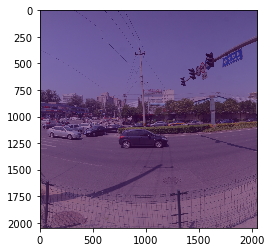

In [53]:
apply_model(lenet_alldata, X_test)

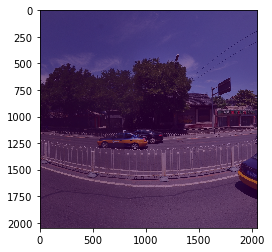

In [52]:
apply_model(alexnet_alldata, X_test)

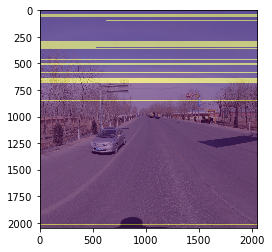

In [24]:
apply_model(lenet_halfdata, X_test)

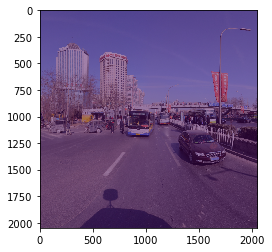

In [25]:
apply_model(alexnet_halfdata, X_test)

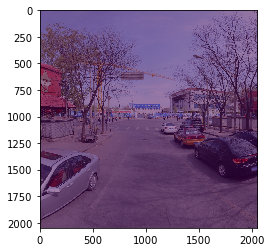

In [41]:
apply_model(lenet_smalldata, X_test)

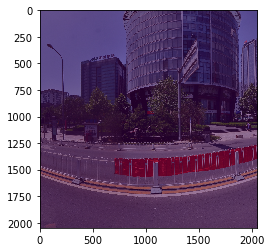

In [42]:
apply_model(alexnet_smalldata, X_test)

In [ ]:
index = np.where(y_train[0] == [1]) # made extra sure labels actually contain 1s and not only 0s

In [ ]:
new_index = index[0][0]

In [ ]:
np.where(y_train[0].squeeze()[new_index] == 1)

In [ ]:
y_train[0].squeeze()[3][950]